# [without library] <font color="orange">MNIST Digits Classification using Gaussian Naive Bayes</font>

### Based on - [2010] Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression - <font color=magenta>Tom Mitchell</font>

<img src="../assets/images/mnist-gnb/gnb.png">

## Introduction

This notebook implements <font color=blue>Gaussian Naive Bayes</font>. It performs <font color=blue>multi-class classification</font> on MNIST Digits dataset consisting of images of size 28 x 28 = 784 attributes and belonging to three classes. There are 70,000 training data points (images) that are divided into 60,000 training and 10,000 test data points. The prediction accuracy is <font color=blue>64%</font>.

Resources:
- [CMU Qatar Lecture Notes - Naive Bayes - Gianni A. Di Caro](https://web2.qatar.cmu.edu/~gdicaro/10315/lectures/315-F19-6-NaiveBayes.pdf)
- [CMU Machine Learning 10-701 - Pradeep Ravikumar](http://www.cs.cmu.edu/~pradeepr/courses/701/2018-fall/Fall2018Slides/NaiveBayes.pdf)
- [CMU Machine Learning 10-701 - Tom Mitchell](https://www.cs.cmu.edu/~tom/10701_sp11/slides/LR_1-27-2011.pdf)
- [How is Naive Bayes a Linear Classifier? - stats.stackexchange](https://stats.stackexchange.com/questions/142215/how-is-naive-bayes-a-linear-classifier#:~:text=In%20general%20the%20naive%20Bayes,in%20a%20particular%20feature%20space.)
- [Naive Bayes classifier - Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Bernoulli_na%C3%AFve_Bayes)

Towards the end, I have included a <font color=blue>sidebar</font> on the <font color=magenta>comparison of Naive Bayes and Logistic Regression</font>. 

## Taxonomy and Notes

> Probabilistic, Generative

Naive Bayes is a <font color=blue>probabilistic</font> classifier. It learns the underlying <font color=blue>joint distribution P(X, Y)</font> by learning the <font color=blue>likelihood distribution P(X\|Y)</font> (a.k.a __class-conditonal__) and the <font color=blue>prior distribution P(Y)</font> (a.k.a __class-prior__). The distribution learnt can be used to generate data. Hence, it is a <font color=blue>generative</font> classifier. Naive bayes does not model the class decision boundaries, but instead models the distribution of the observed data. In Generative Modeling, we learn a full probabilistic model, the joint distribution P(X, Y). We assume a parametric form of the underlying probability distribution, and estimate those parameters from the observed data.

> Parametric

Naive Bayes is <font color=blue>parametric</font> since the distribution assumed to model the likelihood (say, gaussian, multinomial, or bernoulli) have parameters. Gaussian distribution has parameters for mean and standard deviation.

> Linear

In general, the Naive Bayes classifier is not linear. But, it becomes <font color=blue>linear, if the likelihood is exponential</font>. This is because the __log-likelihood becomes linear in the log-space__. <font color=blue>Gaussian</font>, <font color=blue>Multinomial</font>, or <font color=blue>Bernoulli</font> distributions are all from the exponential family of distributions, so Naive Bayes can be applied to data exhibiting these distributions. Under the assumption of an exponential distribution, Bernoulli Naive Bayes maps to Binomial Logistic Regression, and Multinomial Naive Bayes maps to Multinomial Logistic Regression. 

> Event Model

The assumptions on distributions of features are called the <font color=blue>event model</font> of the Naive Bayes classifier.

> Event Model - Continuous Data (MNIST Digit Recognition, Iris Flower Species Classification)

When dealing with __continuous data__, a typical __assumption__ is that the continuous values associated with each class are distributed according to a <font color=blue>normal (or Gaussian) distribution</font>. The Iris Flower Species dataset has attributes that exhibit gaussian distribution.

When assuming Gaussian class-conditionals, <font color=blue>if all class-conditional gaussians have the same covariance</font>, then the quadratic terms cancel out and we are left with a <font color=blue>linear</font> form. To take an example of MNIST dataset, if we asume that the variance across digits is the same, then we have a linear model.

The __class prior__ distribution has to be a <font color=blue>discrete distribution</font> (say, multinoulli) that distributes the probability of a data point belonging to class among K possible classes.

Note: Sometimes the distribution of class-conditional marginal densities is __far from normal__. In these cases, <font color=blue>kernel density estimation</font> can be used for a more realistic estimate of the marginal densities of each class.

> Event Model - Discrete Data (Text Classification)

For __discrete features__ (document classification), Multinomial and Bernoulli distributions are popular. With a multinomial event model, features represent frequencies of events (say, count of word occurrences). With a bernoulli event model, features represent presence or absence of events (say, presence or absence of words).

> Binary and Multiclass

Naive Bayes can be both <font color=blue>binary and multiclass</font>.

> Summary

In summary, Naive Bayes is:
- Probabilistic
- Generative
- Binary and Multiclass
- Linear
- Parametric

<img src="../assets/images/mnist-gnb/mmap_nb.png">

> Why Naive?

Naive Bayes makes an assumption that the input attributes are independent of each other. This results in a <font color=blue>significant reduction in the number of parameters</font> the model needs to learn. This is because, since each attribute is assumed to be influenced only by the class its data poin belongs to, the model only has P(X_i\|Y_k) terms, and no P(X_i\|X_j), P(X_i\|X_j, X_k), etc terms. This is the reason the model is called '<font color=blue>Naive</font>' because it is seldom the case that the input attributes do not influence each other. Still, Naive Bayes has proven to be effective.

Due to the modeling assumptions of attributes being independent, Naive Bayes model introduces <font color=red>a lot more inductive bias</font> as compared to Logistic Regression. This also results in  <font color=green>faster convergence</font> of order O(log N) (N is the number of data points). The fast convergence can perhaps be on  <font color=red>less accurate</font> estimates.

> Algebraically solved Closed-Form

Naive Bayes class-conditional probabilities (<font color=blue>maximum likelihood estimation</font>) can be deduced analytically. Also, the class-priors can be deduced using frequentist methods. So, there is a <font color=blue>closed-form</font> solution to Naive Bayes. And, hence, we <font color=blue>do not need a numerical method like gradient descent</font>.

## Imports

In [1]:
import math #to check for nan
import numpy as np
from numpy import mean, std #mean and standard deviation for gaussian probabilities
from scipy.stats import norm #gaussian probabilities
from math import log # to calculate posterior probability
from random import sample #for random sampling of data points
import tensorflow as tf
import matplotlib.pyplot as plt #display images of digits
%matplotlib inline

## Data

### Read

#### Load mnist data from Tensorflow Keras library

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#### Sanity check for data getting loaded

In [3]:
print([i.shape for i in (x_train, y_train, x_test, y_test)])
print([type(i) for i in (x_train, y_train, x_test, y_test)])
print('classes, num_classes: ', np.unique(y_train), len(np.unique(y_train)))

[(60000, 28, 28), (60000,), (10000, 28, 28), (10000,)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
classes, num_classes:  [0 1 2 3 4 5 6 7 8 9] 10


#### visualize

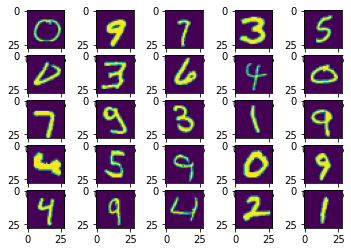

In [4]:
def visualize(rows, cols, x_, l_i):
    fig = plt.figure() #create a figure
    axes = [] #accumulate axes of subplots we create in the figure
    #for i_subplot in range rows*cols
    for i_sp in range(rows*cols): #iterate row * col times
        axes.append(fig.add_subplot(rows, cols, i_sp + 1)) #create a new subplot and accumulate its axis
        plt.imshow(x_[l_i[i_sp]])
        
m, n = 5, 5
visualize(m, n, x_train, sample(range(x_train.shape[0]), m*n))

## Model

### Training Algorithm

<img src="../assets/images/mnist-gnb/gnb_mean_std.png">

In [5]:
<img src="../assets/images/iris-gnb/gnb_mean_std.png">'''
    return
            classes: (list) of unique class names in the dataset,
             got from the last column named class_colname.
             
            features: (list) of features (column names) in the dataset.
             this excludes the last column which we expect it to have the class labels.
             
            prior: (1-d array) of dim num_classes
            (prior probability of a set of features belonging to a class)
            
            mean_std: (3-d array) of dim num_classes x num_features x 2 (2: mean and std)
            (mean and standard deviation for all features, given the class)
            
    arguments:
    df: (dataframe) with features and class names (should have a 'class' column in addition to the feature columns).
    class_colname: (string) provide suitable column name otherwise, using the class_colname argument.
'''
def train_gaussian_nb(X, y):
    #number of classes
    classes = np.unique(y)
    num_classes = len(classes)
    #number of data points and features
    N, dim_x, dim_y = X.shape[0], X.shape[1], X.shape[2]
    
    #data structures for priors and
    # (mean, standard deviation) pairs for each feature and class
    # to later calculate likelihood (conditional probability of feature given class)
    prior = np.zeros(num_classes, dtype=float)
    X_mean = np.empty((num_classes, dim_x, dim_y), dtype=float)
    X_std = np.empty((num_classes, dim_x, dim_y), dtype=float)
    
    #for each class...
    for cls in range(num_classes):
        #use a boolean index list to extract images of this class
        bool_idx_list = [True if c==cls else False for c in y]
        X_cls = X[bool_idx_list]
        
        #calculate prior probability of data point belonging to class cls
        prior[cls] = len(X_cls) / N

        #for each dim_x by dim_y, calculate mean and std, across all data points of this class
        X_mean[cls] = mean(X_cls, axis=0)
        X_std[cls] = std(X_cls, axis=0)
            
    return classes, dim_x, dim_y, prior, X_mean, X_std

### Prediction Algorithm

<a href="https://www.codecogs.com/eqnedit.php?latex=P\left&space;(&space;X_{i}=x|Y=y_{k}&space;\right&space;)=\frac{1}{\sigma&space;_{ik}\sqrt{2\pi&space;}}e^{\frac{-\left&space;(&space;x-\mu&space;_{ik}&space;\right&space;)^{2}}{2\sigma&space;_{ik}^{2}}}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?P\left&space;(&space;X_{i}=x|Y=y_{k}&space;\right&space;)=\frac{1}{\sigma&space;_{ik}\sqrt{2\pi&space;}}e^{\frac{-\left&space;(&space;x-\mu&space;_{ik}&space;\right&space;)^{2}}{2\sigma&space;_{ik}^{2}}}" title="P\left ( X_{i}=x|Y=y_{k} \right )=\frac{1}{\sigma _{ik}\sqrt{2\pi }}e^{\frac{-\left ( x-\mu _{ik} \right )^{2}}{2\sigma _{ik}^{2}}}" /></a>

In [6]:
'''
    return (integer) the (0-based) index of class to which the document belongs
    
    arguments:
    num_classes: (int) number of classes
    num_features: (int) number of features
    prior: (1-d array) of dim num_classes
           (prior probability of a set of features belonging to a class)
    mean_std: (3-d array) of dim num_classes x num_features x 2 (2: mean and std)
              (mean and standard deviation for all features, given the class)
    x: (list) of features
'''
def apply_gaussian_naive_bayes(num_classes, dim_x, dim_y, prior, X_mean, X_std, x):
    score = np.zeros((num_classes), dtype=float)
    
    #for each class...
    for cls in range(num_classes):
        
        #for this class, add the log-prior probability to the score
        score[cls] += log(prior[cls], 10) #log to the base 10
        
        #for each feature, add the log-likelihood to the score
        for i_x in range(dim_x):
            for i_y in range(dim_y):
                #calculate likelihood from the trained mean and standard deviation
                mu = X_mean[cls][i_x][i_y]
                sigma = X_std[cls][i_x][i_y]
                likelihood = norm(mu, sigma).pdf(x[i_x][i_y])
                #print(mu, sigma, x[i_x][i_y], likelihood)

                #add the log-likelihood to the score
                
                #ValueError exception raised if likelihood is 0 and we take a log.
                #To avoid this, we skip adding log_likelihood to the score.
                #We may argue that score should be penalized for
                # such a great mismatch of pixel intensity for a class,
                # but, these pixels are more of a candidate of noise, and can be ignored.
                #Also, skip NaN values for likelihood (when mu and sigma are 0 and so is x)
                if (math.isnan(likelihood) == True or likelihood == 0):
                    continue
                
                #print(likelihood)
                score[cls] += log(likelihood, 10) #log to the base 10

    #return the index of class with the maximum-a-posterior probability
    return score.argmax()

### Learn

#### Learn

In [7]:
#train the prior and likelihood on observed data (x_train, y_train)
classes, dim_x, dim_y, prior, X_mean, X_std = train_gaussian_nb(x_train, y_train)

#### Sanity check the priors

Note that all priors are nearly 10% probable, since we have 10 digits and balanced-class data.

In [8]:
print('Prior Probability P(Y) of the 10 digits:\n', prior)

Prior Probability P(Y) of the 10 digits:
 [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]


#### Sanity check the trained mean and standard deviation

#### mean

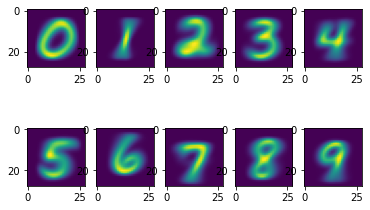

In [9]:
m, n = 2, 5
visualize(m, n, X_mean, [i for i in range(m*n)])

##### standard deviation

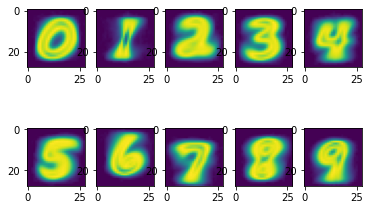

In [10]:
m, n = 2, 5
visualize(m, n, X_std, [i for i in range(m*n)])

## Prediction

In [11]:
#iterate over test dataset and count the number of correct and incorrect predictions
count_correct, count_incorrect = 0, 0
#since each prediction is taking ~6 seconds, we can predict 10 digits per minute.
#allowing the classification to run for 10 minutes, we will have 100 predictions.
#so, setting the range as 0..100

l_pred_cls = []

for i in range(50): #len(x_test)):
    #actual class
    actual_cls = y_test[i]
    #predicted class
    # input provided as row[:-1].to_list(), means, all columns except last, converted to a list
    pred_cls = apply_gaussian_naive_bayes(len(classes), dim_x, dim_y, prior, X_mean, X_std, x_test[i])
    l_pred_cls.append(pred_cls)
    if classes[pred_cls] == actual_cls:
        count_correct += 1
    else:
        count_incorrect += 1
    #print('(predicted, actual):', pred_cls, actual_cls)

C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\jeete\.conda\envs\Python37Env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


### <font color=magenta>Prediction Accuracy</font>

In [12]:
print('Correct: ', count_correct, 'Incorrect: ', count_incorrect)
print('Percentage of correct predictions: ', (count_correct * 100)/(count_correct + count_incorrect))

Correct:  29 Incorrect:  21
Percentage of correct predictions:  58.0


## Sidebar - Comparison of Naive Bayes and Logistic Regression

> [Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression - <font color=magenta>Tom Mitchell</font>](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)

### <font color=magenta>Same Parametric Form</font> (under attribute independence assumptions)

The parametric form of P(Y\|X) used by Logistic Regression is precisely the form implied by the assumptions of a Gaussian Naive Bayes clasifier.

<img src="../assets/images/mnist-gnb/relation_gaussian_nb_to_logreg.png">

### <font color=magenta>Attribute Independence Assumption</font>; <font color=magenta>Convergence</font>; <font color=magenta>Input Data Size</font>

<img src="../assets/images/mnist-gnb/relation_gaussian_nb_to_logreg_indep_assump_and_convergence.png">

### <font color=magenta>Asymptotic Comparison</font>

<img src="../assets/images/mnist-gnb/gnb_logreg_asympto_comp.png">

### <font color=magenta>Summary</font>

<img src="../assets/images/mnist-gnb/gnb_logreg_comp_summary.png">